In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sys; sys.path.insert(0, '..')
from scripts.python.helpers import loadFeatureFilesFromImageTypes, loadImageDatasetConfig
from scripts.python.correlation_functions import getFeatureCorrelations

In [2]:
os.getcwd()

'/Users/katyscott/Documents/analyze_readii_outputs/workflow/notebooks'

# Load config file

In [3]:
dataset_name = "RADCURE"
config = loadImageDatasetConfig(dataset_name,
                                config_dir_path="../config")

# Set image feature extraction method

In [4]:
# Must be one of the directories in the procdata/{dataset_name} directory (not clinical)
extraction_method = "radiomics"
# extraction_method = "deep_learning"

print(f"Analyzing {extraction_method} features.")

Analyzing radiomics features.


# Load all feature sets

In [5]:
extracted_image_feature_dir = f"../../procdata/{dataset_name}/{extraction_method}/train_test_split/train_features"
image_feature_sets = loadFeatureFilesFromImageTypes(extracted_feature_dir = extracted_image_feature_dir,
                                image_types=config["image_types"],
                                drop_labels=True)

In [6]:
print("Feature sets available for analysis:")
for feature_set in image_feature_sets.keys():
    print("  ->", feature_set)

Feature sets available for analysis:
  -> original
  -> shuffled_full
  -> shuffled_roi
  -> shuffled_non_roi
  -> randomized_sampled_full
  -> randomized_sampled_roi
  -> randomized_sampled_non_roi


# Correlation Calculations

In [7]:
# Set up which feature sets to analyze
# This feature set will be used for the vertical axis (y-axis)
feature_set_vertical = "original"
# This feature set will be used for the horizontal axis (x-axis)
feature_set_horizontal = "original"

In [9]:
# Set up features for correlation calculation
vertical_features = image_feature_sets[feature_set_vertical]
horizontal_features = image_feature_sets[feature_set_horizontal]

# Calculate Pearson correlation matrix
feature_correlation_matrix = getFeatureCorrelations(vertical_features = vertical_features, 
                                                    horizontal_features = horizontal_features,
                                                    method = "pearson",
                                                    vertical_feature_name=feature_set_vertical,
                                                    horizontal_feature_name=feature_set_horizontal)

# Diagonal matrix of correlations

In [22]:
# Get lower triangle of correlation matrix
diagonal_correlation_matrix = np.tril(feature_correlation_matrix)
lower_half_idx = np.mask_indices(len(feature_correlation_matrix), np.tril)

diagonal_plot = sns.heatmap(diagonal_correlation_matrix,
                            mask = lower_half_idx,
                             cmap="nipy_spectral")
diagonal_plot.set(xlabel=feature_set_horizontal, ylabel=feature_set_vertical, xticklabels=[], yticklabels=[])

ValueError: Unable to coerce list of <class 'numpy.ndarray'> to Series/DataFrame

# Distribution of corrrelations between features

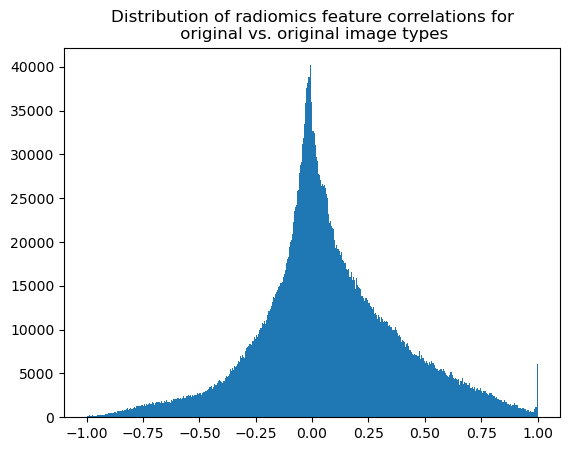

In [20]:
# flatten the correlation matrix to a vector
diagonal_matrix_values = diagonal_correlation_matrix[lower_half_idx]

correlation_distribution = np.histogram(diagonal_matrix_values, bins=100)
plt.hist(diagonal_matrix_values, bins='auto')
plt.title(f"Distribution of {extraction_method} feature correlations for\n {feature_set_vertical} vs. {feature_set_horizontal} image types")
plt.show()

# Original vs Original correlation analysis

In [12]:
# matrix = np.triu(correlationMatrix)

In [32]:
len(correlationMatrix)/2 + 108

1425.0

In [ ]:
correlationMatrix.iloc[0:108, 1317:1425]

### No filter features

[Text(0.5, 23.38159722222222, 'shuffled_non_roi'),
 Text(50.581597222222186, 0.5, 'original'),
 [Text(0.5, 0, ''),
  Text(4.5, 0, ''),
  Text(8.5, 0, ''),
  Text(12.5, 0, ''),
  Text(16.5, 0, ''),
  Text(20.5, 0, ''),
  Text(24.5, 0, ''),
  Text(28.5, 0, ''),
  Text(32.5, 0, ''),
  Text(36.5, 0, ''),
  Text(40.5, 0, ''),
  Text(44.5, 0, ''),
  Text(48.5, 0, ''),
  Text(52.5, 0, ''),
  Text(56.5, 0, ''),
  Text(60.5, 0, ''),
  Text(64.5, 0, ''),
  Text(68.5, 0, ''),
  Text(72.5, 0, ''),
  Text(76.5, 0, ''),
  Text(80.5, 0, ''),
  Text(84.5, 0, ''),
  Text(88.5, 0, ''),
  Text(92.5, 0, ''),
  Text(96.5, 0, ''),
  Text(100.5, 0, ''),
  Text(104.5, 0, '')],
 [Text(0, 0.5, ''),
  Text(0, 5.5, ''),
  Text(0, 10.5, ''),
  Text(0, 15.5, ''),
  Text(0, 20.5, ''),
  Text(0, 25.5, ''),
  Text(0, 30.5, ''),
  Text(0, 35.5, ''),
  Text(0, 40.5, ''),
  Text(0, 45.5, ''),
  Text(0, 50.5, ''),
  Text(0, 55.5, ''),
  Text(0, 60.5, ''),
  Text(0, 65.5, ''),
  Text(0, 70.5, ''),
  Text(0, 75.5, ''),
  Te

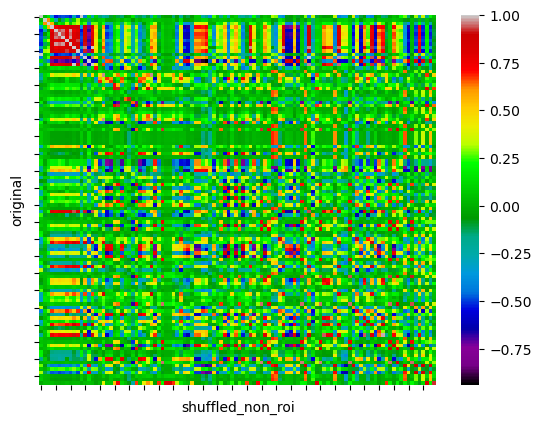

In [46]:
s = sns.heatmap(correlationMatrix.iloc[0:108, 1317:1425], cmap="nipy_spectral")
s.set(xlabel=horizontalPrefix, ylabel=verticalPrefix, xticklabels=[], yticklabels=[])
# plt.tick_params(labelbottom=False, bottom=False, labeltop=True, top=True)
# s.set_xticklabels(s.get_xticklabels(), rotation=40, ha="right")

### Wavelet Features

[Text(0.5, 23.38159722222222, 'shuffled_roi_'),
 Text(50.58159722222219, 0.5, 'original')]

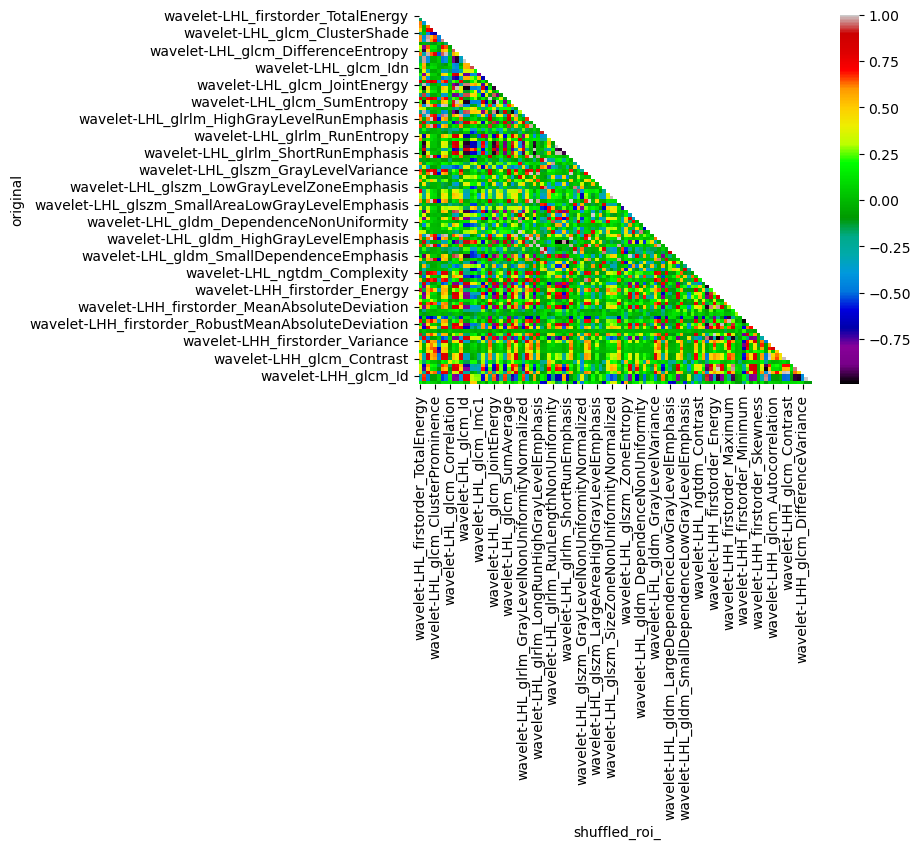

In [15]:
s = sns.heatmap(correlationMatrix.iloc[216:324, 216:324], mask=matrix[0:108, 0:108], cmap="nipy_spectral")
s.set(xlabel=horizontalPrefix, ylabel=verticalPrefix)